In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
# importing libraries

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import math

import warnings
warnings.filterwarnings("ignore")

In [3]:
# function which plots ibm stock prices: real and predicted both

def plot_predictions(test, predicted):
    plt.plot(test, color="red", label="real IBM stock price")
    plt.plot(predicted, color="blue", label="predicted stock price")
    plt.title("IBM stock price prediction")
    plt.xlabel("time")
    plt.ylabel("IBM stock price")
    plt.legend()
    plt.show()

In [4]:
# function which calculates root mean squared error

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is : {}.".format(rmse))

In [5]:
data = pd.read_csv("C:\\Users\\hp\Desktop\\data\\AAPL.csv", index_col='Date', parse_dates=["Date"])

data.shape

(2515, 6)

In [6]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-09-20,24.969999,25.002144,24.772142,24.953571,21.271446,336568400
2012-09-21,25.086071,25.181070,24.977142,25.003214,21.313765,571589200
2012-09-24,24.530714,24.825714,24.392857,24.671070,21.030632,639766400
2012-09-25,24.580713,24.742144,24.035713,24.055000,20.505465,518789600
2012-09-26,23.883572,24.024643,23.614286,23.756430,20.250948,576503200


In [46]:
train = data[:'2020'].iloc[:,1:2].values
test = data['2021':].iloc[:,1:2].values

len(test)

431

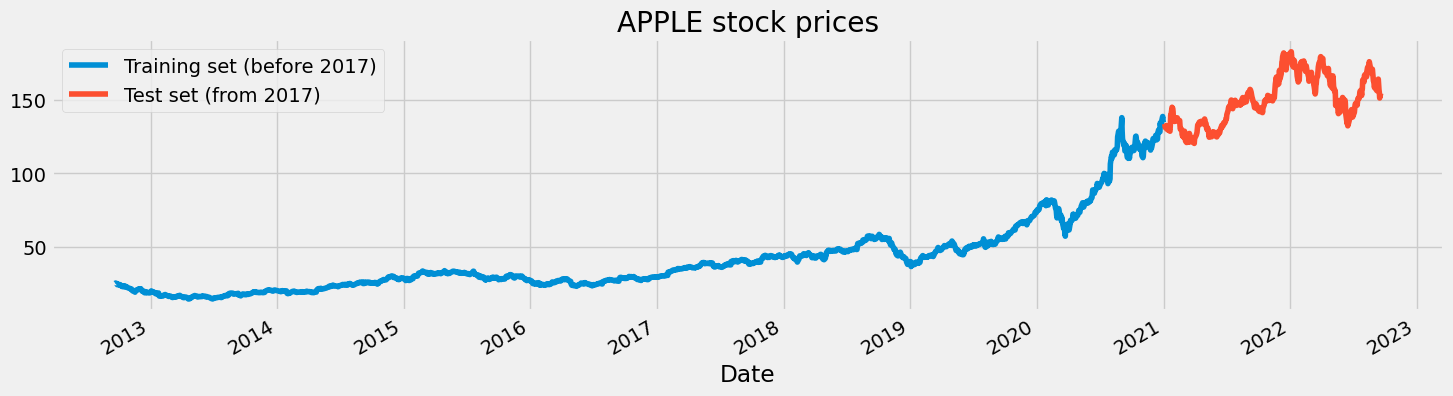

In [47]:
# visualization of "High" attribute of the dataset

data["High"][:'2020'].plot(figsize=(16,4), legend=True)
data["High"]["2021":].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (before 2017)", "Test set (from 2017)"])
plt.title("APPLE stock prices")
plt.show()

In [48]:
# scaling the training set

sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)

In [50]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements

x_train = []
y_train = []

for i in range(60,2050):
    x_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [51]:
x_train[0]

array([0.08617763, 0.08761457, 0.08476073, 0.08408959, 0.07832739,
       0.08104643, 0.0807424 , 0.07949187, 0.07650895, 0.07808934,
       0.07877482, 0.07640856, 0.07111964, 0.06909182, 0.07037963,
       0.07101637, 0.06762617, 0.06755447, 0.07190551, 0.07261969,
       0.06954212, 0.06659075, 0.06762617, 0.06720168, 0.06509356,
       0.06378854, 0.06149399, 0.05804068, 0.05833896, 0.05660372,
       0.05397072, 0.05482257, 0.0501761 , 0.04664537, 0.04453724,
       0.04442826, 0.04327524, 0.04240618, 0.04012597, 0.03740119,
       0.0481569 , 0.04943325, 0.04811961, 0.04944759, 0.05461032,
       0.0547308 , 0.05340569, 0.0558293 , 0.05415142, 0.05592683,
       0.0522584 , 0.04865883, 0.04408693, 0.04462902, 0.03984202,
       0.04301138, 0.04256393, 0.03959249, 0.03399664, 0.034533  ])

In [52]:
y_train[0]

0.038806599150950666

In [53]:
len(x_train)

1990

In [54]:
len(y_train)

1990

In [55]:
x_train.shape

(1990, 60)

In [56]:
y_train.shape

(1990,)

In [57]:
# reshaping x_train for efficient modelling

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [58]:
x_train.shape

(1990, 60, 1)

In [59]:
# LSTM architecture

regressor = Sequential()

# add first layer with dropout

regressor.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.2))

# add second layer

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# add third layer

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# add fourth layer

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# the output layer

regressor.add(Dense(units=1))

In [60]:
# compiling the LSTM RNN network

regressor.compile(optimizer='rmsprop', loss='mean_squared_error')

# fit to the training set

regressor.fit(x_train, y_train, epochs=5, batch_size=32)

Epoch 1/5
63/63 [==============================] - 22s 196ms/step - loss: 0.0088
Epoch 2/5
63/63 [==============================] - 12s 189ms/step - loss: 0.0034
Epoch 3/5
63/63 [==============================] - 12s 191ms/step - loss: 0.0029
Epoch 4/5
63/63 [==============================] - 12s 189ms/step - loss: 0.0023
Epoch 5/5
63/63 [==============================] - 14s 216ms/step - loss: 0.0020


In [63]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 'High' attribute data for processing

dataset_total = pd.concat((data['High'][:'2020'], data['High']['2021':]), axis=0)
print(dataset_total.shape)

inputs = dataset_total[len(dataset_total)-len(test)-60 : ].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
print(inputs.shape)
inputs = sc.transform(inputs)
print(inputs.shape)

(2515,)
(491,)
(491, 1)
(491, 1)


In [66]:
# preparing x_test

x_test = []
for i in range(60,491):
    x_test.append(inputs[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
# predicting the stock prices for test set

predicted = regressor.predict(x_test)
predicted = sc.inverse_transform(predicted)

14/14 [==============================] - 1s 59ms/step


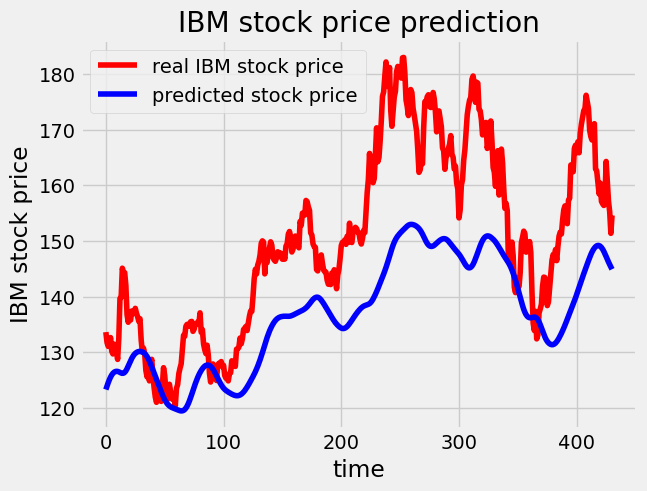

In [67]:
# visualizing the results: predicted vs test

plot_predictions(test, predicted)

In [68]:
# evaluating the model

return_rmse(test, predicted)

the root mean squared error is : 16.0106713091885.


In [69]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

In [70]:
# compiling the model

regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')

# fitting the model

regressorGRU.fit(x_train, y_train, epochs=5, batch_size=150)

Epoch 1/5
14/14 [==============================] - 14s 281ms/step - loss: 0.0383
Epoch 2/5
14/14 [==============================] - 4s 280ms/step - loss: 0.0241
Epoch 3/5
14/14 [==============================] - 4s 279ms/step - loss: 0.0167
Epoch 4/5
14/14 [==============================] - 4s 279ms/step - loss: 0.0096
Epoch 5/5
14/14 [==============================] - 4s 278ms/step - loss: 0.0044


14/14 [==============================] - 3s 79ms/step


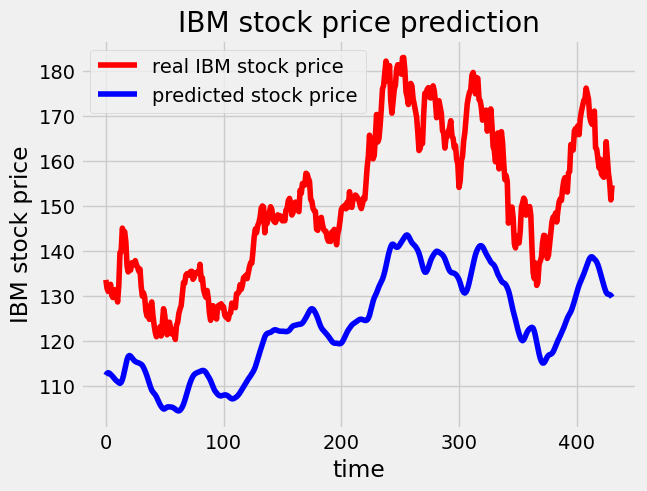

In [71]:
# predicting the stock prices for test set and visualization

predicted_with_gru = regressorGRU.predict(x_test)
predicted_with_gru = sc.inverse_transform(predicted_with_gru)

plot_predictions(test, predicted_with_gru)

In [72]:
# evaluating the model performance

return_rmse(test, predicted_with_gru)

the root mean squared error is : 27.481374984745752.
